In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
import seaborn as sns
import shapely
import shapely.ops
import shapely.geometry
from sklearn.cluster import KMeans
from skimage.segmentation import flood_fill, flood
from skimage import filters, measure

sns.set()

In [2]:
viet_mesh = pv.read('./viet/V2_2_105.75_15.98_tile_1_1.stl')
viet_plane = viet_mesh.project_points_to_plane().points
viet_edge = viet_mesh.project_points_to_plane().extract_feature_edges().points
viet_bounds = viet_mesh.bounds

n_pieces = 16

In [3]:
kmeans = KMeans(n_clusters=n_pieces, random_state=0).fit(viet_plane[:,:2])
clusters = kmeans.predict(viet_plane[:,:2])
vor = Voronoi(kmeans.cluster_centers_, qhull_options='Qbb Qc Qx')

region_bbox = shapely.geometry.Polygon(zip(
    [viet_plane[:,0].min()-5, viet_plane[:,0].min()-5, viet_plane[:,0].max()+5, viet_plane[:,0].max()+5, viet_plane[:,0].min()-5], 
    [viet_plane[:,1].min()-5, viet_plane[:,1].max()+5, viet_plane[:,1].max()+5, viet_plane[:,1].min()-5, viet_plane[:,1].min()-5]
))

In [4]:
viet_plane_df = pd.DataFrame(viet_plane, columns=['x','y','z'])
viet_plane_df['cluster'] = clusters

pieces = []
for g, gdf in viet_plane_df.groupby('cluster'):
    hull = ConvexHull(gdf[['x','y']].values)
    p = hull.points[hull.vertices]
    
    poly = shapely.geometry.Polygon(p)
    pieces.append(poly)

connected_pieces = []
for idx, p0 in enumerate(pieces):
    for jdx, p1 in enumerate(pieces[idx+1:], idx+1):
        if idx == jdx: continue
        line = shapely.geometry.LineString([p0.centroid, p1.centroid])
        poly_intersections = [(i, line.intersection(p).length) for i, p in enumerate(pieces) if line.intersects(p)]
        if len(poly_intersections) == 2:
            if (poly_intersections[0][1] + poly_intersections[1][1]) / line.length > 0.9:
                connected_pieces.append([(i,pieces[i].centroid.coords[0]) for i, length in poly_intersections])
        
for (i, c0),(j,c1) in connected_pieces:
    line = shapely.geometry.LineString([c0, c1])
    near_center_point = line.interpolate(0.65, normalized=True)
    near_center_point_poly = shapely.geometry.LineString([line.coords[0], near_center_point]).buffer(0.5)
    near_center_point_poly = shapely.ops.cascaded_union([near_center_point_poly, near_center_point.buffer(1.5)])
    
    pieces[i] = shapely.ops.cascaded_union([pieces[i], near_center_point_poly]).buffer(-0.01)
    pieces[j] = pieces[j].difference(near_center_point_poly.buffer(0.01))

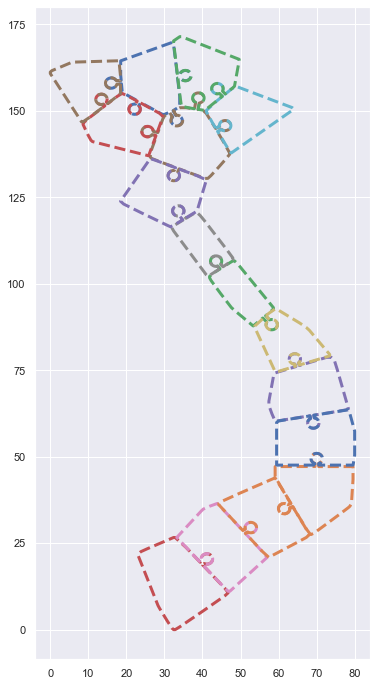

In [5]:
fig, ax = plt.subplots(1, figsize=(6,12))
# ax.scatter(viet_plane[:,0], viet_plane[:,1], c=clusters, alpha=1, s=10)
# ax.scatter(viet_edge[:,0], viet_edge[:,1], alpha=0.4)
for p in pieces:
    x, y = p.exterior.xy
    plt.plot(x,y,lw=3,ls='--')
plt.show()

In [6]:
pieces_3d = []

for idx, p in enumerate(pieces):
    x, y = p.buffer(-0.05).boundary.xy
    x.append(x[0])
    y.append(y[0])
    
    z_low = np.full(len(x), viet_bounds[4]-1)
    z_high = np.full(len(x), viet_bounds[5]+1)
    piece_3d = np.zeros(shape=(2*len(x), 3))
    piece_3d[:,0], piece_3d[:,1] = np.hstack([x,x]), np.hstack([y,y])
    piece_3d[:,2] = np.hstack([z_low, z_high])
    
    piece_3d_lines = [[2,i,i+1] for i in range(len(x)-1)]
    piece_3d_lines.extend([[2,len(x)+i,len(x)+i+1] for i in range(len(x)-1)])
    piece_3d_lines.extend([[2,i,i+len(x)] for i in range(len(x))])

    top_face = [len(x)]
    top_face.extend(list(range(len(x))))
    bot_face = [len(x)]
    bot_face.extend(list(range(len(x), 2*len(x))))

    side_faces = [[4,idx,idx+1,idx+len(x)+1,idx+len(x)] for idx in range(len(x)-1)]
    side_faces.append([4,0,len(x)-1,2*len(x)-1,len(x)])
    side_faces = np.vstack(side_faces)

    faces = np.hstack([top_face, bot_face])
    faces = np.append(faces, side_faces)

    piece_3d = pv.PolyData(piece_3d, faces)
    piece_3d['my labels'] = [f"idx:{i}" for i in range(piece_3d.n_points)]


    piece_3d.lines = piece_3d_lines
    piece_3d = piece_3d.clip_surface(piece_3d)

    pieces_3d.append(piece_3d)

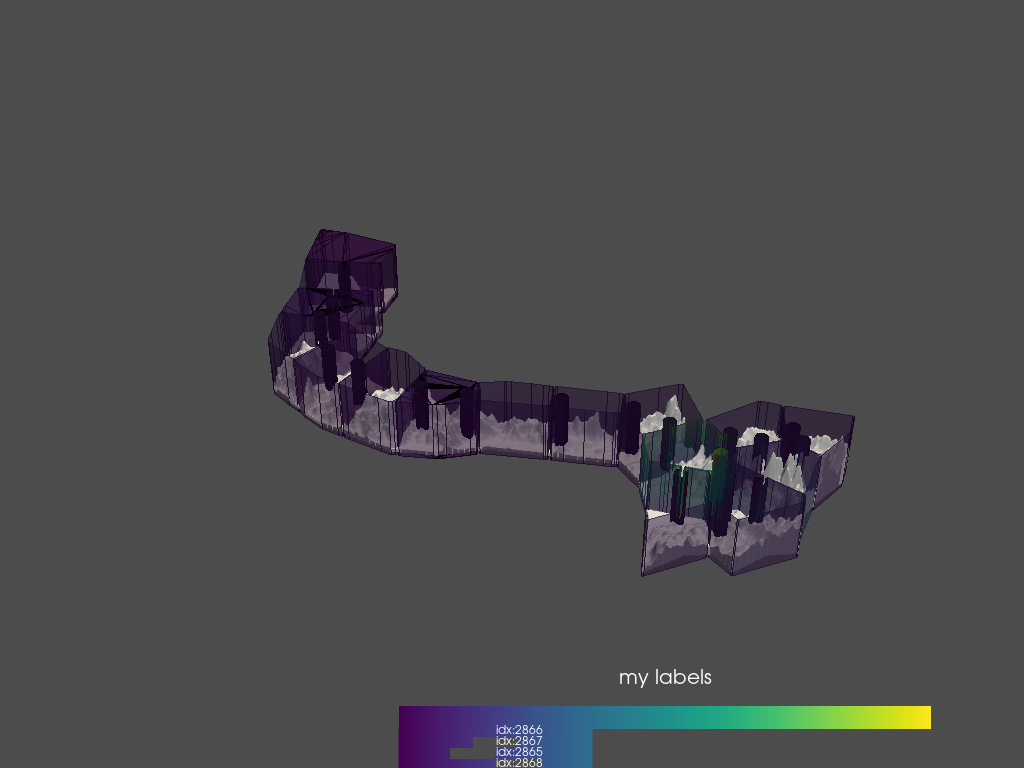

[(251.8547644369714, 297.5983557455652, 219.08258054186032),
 (40.0, 85.74359130859375, 7.227816104888916),
 (0.0, 0.0, 1.0)]

In [11]:
p = pv.Plotter()
for piece in pieces_3d:
    p.add_mesh(piece, opacity=0.5, show_edges=True)
p.add_mesh(viet_mesh)
p.show()

In [8]:
viet_mesh_pieces = [
    viet_mesh.select_enclosed_points(p, check_surface=False).threshold(0.01)
    for p in pieces_3d
]

In [9]:
# p = pv.Plotter()
for idx, piece in enumerate(viet_mesh_pieces):
#     p.add_mesh(piece, opacity=0.5, show_edges=False)
    path = f"./Pieces/viet_piece_{idx+1:03}_{n_pieces:03}.stl"
#     piece.save(path)
# p.add_mesh(viet_mesh)
# p.show()

In [10]:
import pymeshfix

fixer = pymeshfix.MeshFix(piece)
fixer.repair(joincomp=True, remove_smallest_components=False)

fixer.mesh.plot(notebook=True, opacity=0.5, show_edges=True)

# for piece in pieces_3d:
#     piece.plot()

AttributeError: 'MeshFix' object has no attribute 'f'

In [ ]:
type(piece)